# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import model_tool
import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


HELLO from model_tool


In [2]:
from model_tool import (DEFAULT_EMBEDDINGS_PATH,
DEFAULT_MODEL_DIR, DEFAULT_HPARAMS, ToxModel)
from keras.utils import to_categorical
from keras.layers import Multiply
from keras.callbacks import TensorBoard


#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))



class AttentionToxModel(ToxModel):
    def __init__(self,
                 model_name=None,
                 model_dir=DEFAULT_MODEL_DIR,
                 embeddings_path=DEFAULT_EMBEDDINGS_PATH,
                 hparams=None):
        self.model_dir = model_dir
        self.model_name = model_name
        self.model = None
        self.tokenizer = None
        self.hparams = DEFAULT_HPARAMS.copy()
        self.embeddings_path = embeddings_path
        if hparams:
            self.update_hparams(hparams)
        if model_name:
            self.load_model_from_name(model_name)
            self.load_probs_model(model_name)
        self.print_hparams()

    def load_probs_model(self, model_name):
        probs_model_name = model_name + "_probs"
        self.probs_model = load_model(
                os.path.join(
                    self.model_dir, '%s_model.h5' % probs_model_name))

    def save_prob_model(self):
        self.probs_model_name = self.model_name + "probs"

    def build_dense_attention_layer(self, input_tensor):
        # softmax
        attention_probs = Dense(self.hparams['max_sequence_length'],
                                activation='softmax',
                                name='attention_vec')(input_tensor)
        # context vector
        attention_mul = Multiply()([input_tensor, attention_probs])
        return {'attention_probs': attention_probs,
                'attention_preds': attention_mul}

    def train(
                self,
                training_data_path,
                validation_data_path, text_column,
                label_column, model_name):
        self.model_name = model_name
        self.save_hparams(model_name)

        train_data = pd.read_csv(training_data_path)
        valid_data = pd.read_csv(validation_data_path)

        print('Fitting tokenizer...')
        self.fit_and_save_tokenizer(train_data[text_column])
        print('Tokenizer fitted!')

        print('Preparing data...')
        train_text, train_labels = (self.prep_text(train_data[text_column]),
                                    to_categorical(train_data[label_column]))
        valid_text, valid_labels = (self.prep_text(valid_data[text_column]),
                                    to_categorical(valid_data[label_column]))
        print('Data prepared!')

        print('Loading embeddings...')
        self.load_embeddings()
        print('Embeddings loaded!')

        print('Building model graph...')
        self.build_model()
        print('Training model...')

        preds_save_path = os.path.join(
                            self.model_dir, '%s_model.h5' % self.model_name)
        probs_save_path = os.path.join(
                            self.model_dir, '%s_probs_model.h5'
                            % self.model_name)
        preds_callbacks = [ModelCheckpoint(
                            preds_save_path,
                            save_best_only=True,
                            verbose=self.hparams['verbose']), tensorboard]
        probs_callbacks = [ModelCheckpoint(
                            probs_save_path,
                            save_best_only=True,
                            verbose=self.hparams['verbose']),tensorboard]

        if self.hparams['stop_early']:
            early_stop = EarlyStopping(
                            min_delta=self.hparams['es_min_delta'],
                            monitor='val_loss',
                            patience=self.hparams['es_patience'],
                            verbose=self.hparams['verbose'], mode='auto')
            probs_callbacks.append(early_stop)
            preds_callbacks.append(early_stop)

        self.model.fit(train_text,
                       train_labels,
                       batch_size=self.hparams['batch_size'],
                       epochs=self.hparams['epochs'],
                       validation_data=(valid_text, valid_labels),
                       callbacks=preds_callbacks,
                       verbose=2)

        print('Model trained!')
        print('Best model saved to {}'.format(preds_save_path))
        print('Fitting probs model')

        self.probs_model.fit(
                    train_text,
                    train_labels,
                    batch_size=self.hparams['batch_size'],
                    epochs=self.hparams['epochs'],
                    validation_data=(valid_text, valid_labels),
                    callbacks=probs_callbacks,
                    verbose=2)
        self.probs_model = load_model(probs_save_path)
        print('Loading best model from checkpoint...')
        self.model = load_model(preds_save_path)
        print('Model loaded!')

    def build_model(self):
        print('print inside build model')
        sequence_input = Input(
                            shape=(self.hparams['max_sequence_length'],),
                            dtype='int32')
        embedding_layer = Embedding(
                            len(self.tokenizer.word_index) + 1,
                            self.hparams['embedding_dim'],
                            weights=[self.embedding_matrix],
                            input_length=self.hparams['max_sequence_length'],
                            trainable=self.hparams['embedding_trainable'])

        embedded_sequences = embedding_layer(sequence_input)
        x = embedded_sequences
        for filter_size, kernel_size, pool_size in zip(
                self.hparams['cnn_filter_sizes'],
                self.hparams['cnn_kernel_sizes'],
                self.hparams['cnn_pooling_sizes']):
            x = self.build_conv_layer(x, filter_size, kernel_size, pool_size)

        x = Flatten()(x)
        x = Dropout(self.hparams['dropout_rate'], name="Dropout")(x)
        x = Dense(250, activation='relu', name="Dense_RELU")(x)

        # build prediction model
        attention_dict = self.build_dense_attention_layer(x)
        preds = attention_dict['attention_preds']
        preds = Dense(2, name="preds_dense", activation='softmax')(preds)
        rmsprop = RMSprop(lr=self.hparams['learning_rate'])
        self.model = Model(sequence_input, preds)
        self.model.compile(
                loss='categorical_crossentropy',
                optimizer=rmsprop,
                metrics=['acc'])

        # now make probs model
        probs = attention_dict['attention_probs']
        probs = Dense(2, name='probs_dense')(probs)
        rmsprop = RMSprop(lr=self.hparams['learning_rate'])
        self.probs_model = Model(sequence_input, preds)
        self.probs_model.compile(
                loss='mse', optimizer=rmsprop, metrics=['acc'])
        # build probabilities model
        self.save_prob_model()


In [3]:
%ls ./eval_datasets

bias_madlibs_77k.csv         bias_madlibs_89k_scored.csv
bias_madlibs_77k_scored.csv  toxicity_fuzzed_testset.csv
bias_madlibs_89k.csv         toxicity_nonfuzzed_testset.csv


In [5]:
%%time

MODEL_DIR = '../models/'

# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

atn_model_names = ['bd_debias_random_tox_v1'.format(i) for i in xrange(100, 110)]
atn_models = [model_tool.ToxModel(name) for name in atn_model_names]

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
wiki_models = [model_tool.ToxModel(name) for name in wiki_model_names]

#random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
#random_models = [model_tool.ToxModel(name) for name in random_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
debias_models = [model_tool.ToxModel(name) for name in debias_model_names]



Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 5
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: bd_debias_random_tox_v1
max_sequence_length: 250
stop_early: True
embedding_trainable: False



ResourceExhaustedError: OOM when allocating tensor with shape[159683,100]
	 [[Node: embedding_1_1/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_1_1/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_1_1/embeddings, embedding_1_1/random_uniform)]]

Caused by op u'embedding_1_1/embeddings/Assign', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2828, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2493961fde5c>", line 1, in <module>
    get_ipython().run_cell_magic(u'time', u'', u"\nMODEL_DIR = '../models/'\n\n# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.\n\natn_model_names = ['bd_debias_random_tox_v1'.format(i) for i in xrange(100, 110)]\natn_models = [model_tool.ToxModel(name) for name in atn_model_names]\n\nwiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]\nwiki_models = [model_tool.ToxModel(name) for name in wiki_model_names]\n\n#random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]\n#random_models = [model_tool.ToxModel(name) for name in random_model_names]\n\ndebias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]\ndebias_models = [model_tool.ToxModel(name) for name in debias_model_names]\n")
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2117, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-60>", line 2, in time
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/IPython/core/magics/execution.py", line 1185, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 7, in <module>
  File "model_tool.py", line 119, in __init__
    self.load_model_from_name(model_name)
  File "model_tool.py", line 144, in load_model_from_name
    os.path.join(self.model_dir, '%s_model.h5' % model_name))
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/models.py", line 239, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/models.py", line 313, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/utils/generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/engine/topology.py", line 2497, in from_config
    process_node(layer, node_data)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/engine/topology.py", line 2454, in process_node
    layer(input_tensors[0], **kwargs)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/engine/topology.py", line 575, in __call__
    self.build(input_shapes[0])
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/layers/embeddings.py", line 101, in build
    dtype=self.dtype)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/engine/topology.py", line 399, in add_weight
    constraint=constraint)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 316, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/ops/state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 57, in assign
    use_locking=use_locking, name=name)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/jb/repos/unintended-ml-bias-analysis/venv/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[159683,100]
	 [[Node: embedding_1_1/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_1_1/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_1_1/embeddings, embedding_1_1/random_uniform)]]


In [ ]:
all_model_families = [wiki_models, random_models, debias_models, atn_models]
all_model_families_names = [wiki_model_names, random_model_names, debias_model_names, atn_model_names]

## Load datasets

In [50]:
all_models = wiki_models + random_models + debias_models + atn_models

In [51]:
%%time

madlibs = model_tool.load_maybe_score(
    all_models,
    orig_path='./eval_datasets/bias_madlibs_77k.csv',
    scored_path='./eval_datasets/bias_madlibs_77k_scored.csv',
    postprocess_fn=model_tool.postprocess_madlibs)


2018-03-04 19:52:53.731082 Scoring with wiki_cnn_v3_100...
2018-03-04 19:53:22.855526 Scoring with wiki_cnn_v3_101...
2018-03-04 19:53:51.910800 Scoring with wiki_cnn_v3_102...
2018-03-04 19:54:20.960037 Scoring with wiki_cnn_v3_103...
2018-03-04 19:54:50.008663 Scoring with wiki_cnn_v3_104...
2018-03-04 19:55:19.073458 Scoring with wiki_cnn_v3_105...
2018-03-04 19:55:48.113136 Scoring with wiki_cnn_v3_106...
2018-03-04 19:56:17.190272 Scoring with wiki_cnn_v3_107...
2018-03-04 19:56:46.227148 Scoring with wiki_cnn_v3_108...
2018-03-04 19:57:15.261297 Scoring with wiki_cnn_v3_109...
2018-03-04 19:57:44.303599 Scoring with wiki_debias_random_cnn_v3_100...
2018-03-04 19:58:13.345151 Scoring with wiki_debias_random_cnn_v3_101...
2018-03-04 19:58:42.426920 Scoring with wiki_debias_random_cnn_v3_102...
2018-03-04 19:59:11.453806 Scoring with wiki_debias_random_cnn_v3_103...
2018-03-04 19:59:40.473987 Scoring with wiki_debias_random_cnn_v3_104...
2018-03-04 20:00:09.494120 Scoring with wiki_

In [55]:
%%time

wiki_test = model_tool.load_maybe_score(
    all_models,
    orig_path='../data/wiki_test.csv',
    scored_path='../data/wiki_test_scored.csv',
    postprocess_fn=model_tool.postprocess_wiki_dataset)

2018-03-04 20:19:40.683915 Scoring with wiki_cnn_v3_100...
2018-03-04 20:19:53.617354 Scoring with wiki_cnn_v3_101...
2018-03-04 20:20:06.873848 Scoring with wiki_cnn_v3_102...
2018-03-04 20:20:19.783891 Scoring with wiki_cnn_v3_103...
2018-03-04 20:20:32.708374 Scoring with wiki_cnn_v3_104...
2018-03-04 20:20:45.618891 Scoring with wiki_cnn_v3_105...
2018-03-04 20:20:58.539878 Scoring with wiki_cnn_v3_106...
2018-03-04 20:21:11.460560 Scoring with wiki_cnn_v3_107...
2018-03-04 20:21:24.392662 Scoring with wiki_cnn_v3_108...
2018-03-04 20:21:37.293232 Scoring with wiki_cnn_v3_109...
2018-03-04 20:21:50.190649 Scoring with wiki_debias_random_cnn_v3_100...
2018-03-04 20:22:03.102487 Scoring with wiki_debias_random_cnn_v3_101...
2018-03-04 20:22:16.024533 Scoring with wiki_debias_random_cnn_v3_102...
2018-03-04 20:22:28.946265 Scoring with wiki_debias_random_cnn_v3_103...
2018-03-04 20:22:41.859418 Scoring with wiki_debias_random_cnn_v3_104...
2018-03-04 20:22:54.768134 Scoring with wiki_

In [58]:
%%time

wiki_debias_test = model_tool.load_maybe_score(
    all_models,
    orig_path='../data/wiki_debias_test.csv',
    scored_path='../data/wiki_debias_test_scored.csv',
    postprocess_fn=model_tool.postprocess_wiki_dataset)

wiki_random_test = model_tool.load_maybe_score(
    all_models,
    orig_path='../data/wiki_debias_random_test.csv',
    scored_path='../data/wiki_debias_random_test_scored.csv',
    postprocess_fn=model_tool.postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_debias_test_scored.csv
2018-03-04 20:44:43.436756 Scoring with wiki_cnn_v3_100...
2018-03-04 20:44:56.809892 Scoring with wiki_cnn_v3_101...
2018-03-04 20:45:10.170107 Scoring with wiki_cnn_v3_102...
2018-03-04 20:45:23.530220 Scoring with wiki_cnn_v3_103...
2018-03-04 20:45:36.875153 Scoring with wiki_cnn_v3_104...
2018-03-04 20:45:50.232912 Scoring with wiki_cnn_v3_105...
2018-03-04 20:46:03.606568 Scoring with wiki_cnn_v3_106...
2018-03-04 20:46:16.969301 Scoring with wiki_cnn_v3_107...
2018-03-04 20:46:30.364435 Scoring with wiki_cnn_v3_108...
2018-03-04 20:46:43.740754 Scoring with wiki_cnn_v3_109...
2018-03-04 20:46:57.101218 Scoring with wiki_debias_random_cnn_v3_100...
2018-03-04 20:47:10.804327 Scoring with wiki_debias_random_cnn_v3_101...
2018-03-04 20:47:24.188227 Scoring with wiki_debias_random_cnn_v3_102...
2018-03-04 20:47:37.530746 Scoring with wiki_debias_random_cnn_v3_103...
2018-03-04 20:47:50.893023 Scoring with wiki_debias_

## AUC

Overall AUC on the madlibs dataset improved from 0.956 to 0.973 for the debiased model.

original models:
mean AUC: 0.9473791703871992
median: 0.9519281216174182
stddev: 0.01202941755741397


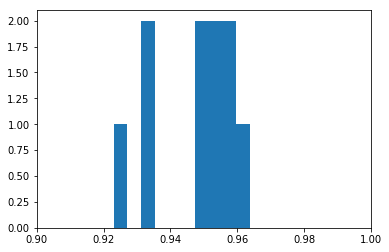



random models:
mean AUC: 0.9533220015812034
median: 0.9531084702340423
stddev: 0.009267172660274402


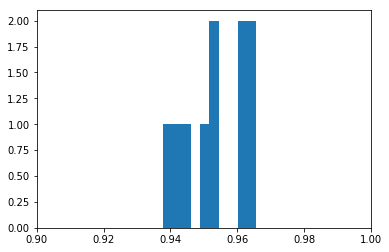



debias models:
mean AUC: 0.9608025866332254
median: 0.9608683624721877
stddev: 0.006214149631866218


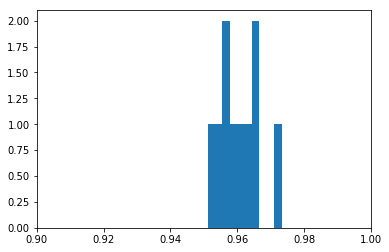


tn models:
mean AUC: 0.9530060524791886
median: 0.958610252456807
stddev: 0.012818738572505196


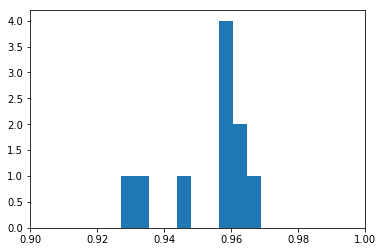

In [59]:
print('original models:')
model_bias_analysis.plot_model_family_auc(madlibs, wiki_model_names, 'label')
print('\n\nrandom models:')
model_bias_analysis.plot_model_family_auc(madlibs, random_model_names, 'label')
print('\n\ndebias models:')
model_bias_analysis.plot_model_family_auc(madlibs, debias_model_names, 'label');
print('\n\atn models:')
model_bias_analysis.plot_model_family_auc(madlibs, atn_model_names, 'label');

In [60]:
for dataset_name, dataset in [('orig test', wiki_test),
                              ('debias test', wiki_debias_test),
                              ('random test', wiki_random_test),
                              ('madlibs', madlibs)]:
    print('\n\nAUCs on', dataset_name)
    for model_family in all_model_families_names:
        fam_name = model_bias_analysis.model_family_name(model_family)
        fam_auc = model_bias_analysis.model_family_auc(dataset, model_family, 'label')
        print('{:30s}  mean {:.4f}\t median {:.4f}\t stddev {:.4f}'.format(fam_name, fam_auc['mean'], fam_auc['median'], fam_auc['std']))



AUCs on orig test
wiki_cnn_v3_10                  mean 0.9590	 median 0.9592	 stddev 0.0022
wiki_debias_random_cnn_v3_10    mean 0.9591	 median 0.9597	 stddev 0.0025
wiki_debias_cnn_v3_10           mean 0.9581	 median 0.9588	 stddev 0.0021
cnn_attention_wiki_tox_v2_10    mean 0.9568	 median 0.9608	 stddev 0.0070


AUCs on debias test
wiki_cnn_v3_10                  mean 0.9560	 median 0.9558	 stddev 0.0019
wiki_debias_random_cnn_v3_10    mean 0.9565	 median 0.9568	 stddev 0.0024
wiki_debias_cnn_v3_10           mean 0.9581	 median 0.9587	 stddev 0.0021
cnn_attention_wiki_tox_v2_10    mean 0.9543	 median 0.9579	 stddev 0.0068


AUCs on random test
wiki_cnn_v3_10                  mean 0.9595	 median 0.9597	 stddev 0.0021
wiki_debias_random_cnn_v3_10    mean 0.9598	 median 0.9604	 stddev 0.0024
wiki_debias_cnn_v3_10           mean 0.9589	 median 0.9595	 stddev 0.0021
cnn_attention_wiki_tox_v2_10    mean 0.9573	 median 0.9612	 stddev 0.0069


AUCs on madlibs
wiki_cnn_v3_10                

## Per-term pinned AUC

Per-term pinned AUC values show improved scores and less disaprity for the debiased model.

In [98]:
def column_renamer(column_name):
    """Helper to make model column names more easily readable."""
    prefix_mapping = {
        'wiki_cnn_v3_10_': 'orig_',
        'wiki_debias_cnn_v3_10_': 'debias_',
        'wiki_debias_random_cnn_v3_10_': 'random_',
        'cnn_attention_wiki_tox_v2_10_': 'attention_',
    }
    for prefix_from, prefix_to in prefix_mapping.iteritems():
        if column_name.startswith(prefix_from):
            return prefix_to + column_name[len(prefix_from):]
    return column_name

In [99]:
madlibs_terms = model_bias_analysis.read_identity_terms('bias_madlibs_data/adjectives_people.txt')

In [100]:
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'text', madlibs_terms)

In [64]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_subgroup_aucs(madlibs, madlibs_terms, all_model_families_names, 'label')

CPU times: user 2.26 s, sys: 0 ns, total: 2.26 s
Wall time: 2.27 s


In [102]:
_term_madlibs_aucs = _raw_term_madlibs_aucs.rename(columns=column_renamer).sort_values('orig_mean')
print(_term_madlibs_aucs.columns)
_term_madlibs_aucs[['subgroup', 'attention_mean', 'attention_std','orig_mean','orig_std', 'random_mean','random_std', 'debias_mean','debias_std']]

Index([u'attention_aucs', u'attention_mean', u'attention_median',
       u'attention_std', u'subgroup', u'subset_size', u'orig_aucs',
       u'orig_mean', u'orig_median', u'orig_std', u'debias_aucs',
       u'debias_mean', u'debias_median', u'debias_std', u'random_aucs',
       u'random_mean', u'random_median', u'random_std'],
      dtype='object')


,subgroup,attention_mean,attention_std,orig_mean,orig_std,random_mean,random_std,debias_mean,debias_std
5,queer,0.877239,0.030826,0.892670,0.042194,0.890695,0.026493,0.930178,0.015959
2,bisexual,0.943179,0.017053,0.928644,0.031313,0.940483,0.016706,0.959942,0.010005
1,gay,0.940150,0.016841,0.931674,0.019837,0.937047,0.012426,0.959577,0.009101
0,lesbian,0.940523,0.018603,0.934130,0.023957,0.944190,0.011090,0.959474,0.009110
8,homosexual,0.943168,0.020361,0.938732,0.022471,0.945094,0.016736,0.964736,0.006794
28,middle eastern,0.951490,0.010971,0.940379,0.015527,0.947799,0.007464,0.953885,0.016507
3,transgender,0.952792,0.015501,0.940618,0.027660,0.950455,0.013958,0.963843,0.007808
30,japanese,0.946089,0.013861,0.942513,0.009240,0.948450,0.008735,0.956400,0.008723
24,canadian,0.951873,0.012041,0.946667,0.010836,0.955395,0.009844,0.956539,0.004074
18,european,0.953292,0.014289,0.947188,0.011229,0.956887,0.008972,0.961798,0.006711


per-term AUC histogram: mean AUCs across terms for: orig_mean


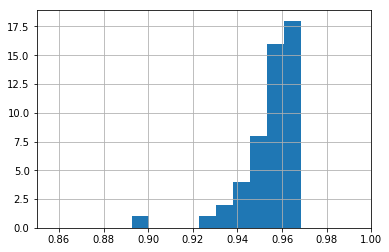

per-term AUC histogram: mean AUCs across terms for: attention_mean


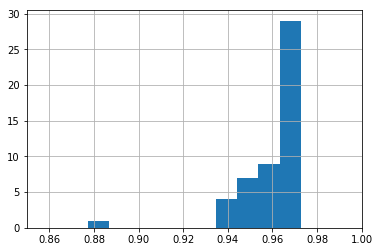

per-term AUC histogram: mean AUCs across terms for: random_mean


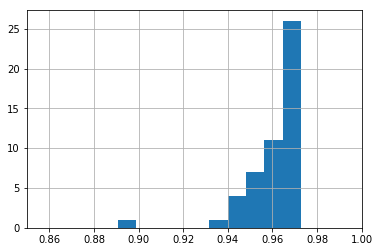

per-term AUC histogram: mean AUCs across terms for: debias_mean


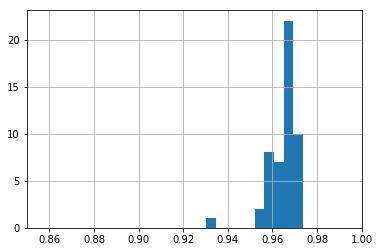

In [103]:
for mean_col in ['orig_mean', 'attention_mean', 'random_mean', 'debias_mean']:
    print('per-term AUC histogram: mean AUCs across terms for:', mean_col)
    _term_madlibs_aucs[mean_col].hist()
    plt.gca().set_xlim((0.85, 1.0))
    plt.show()

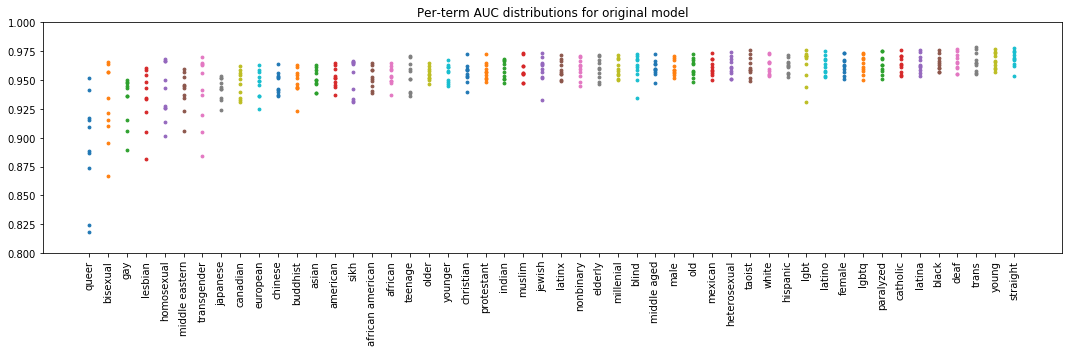

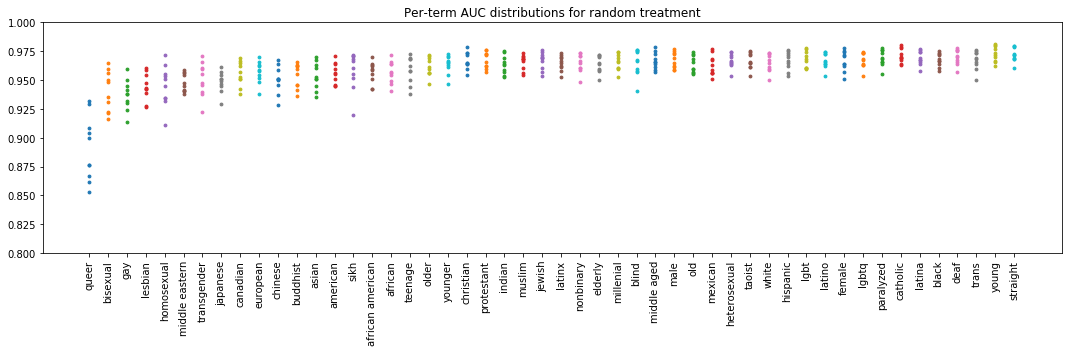

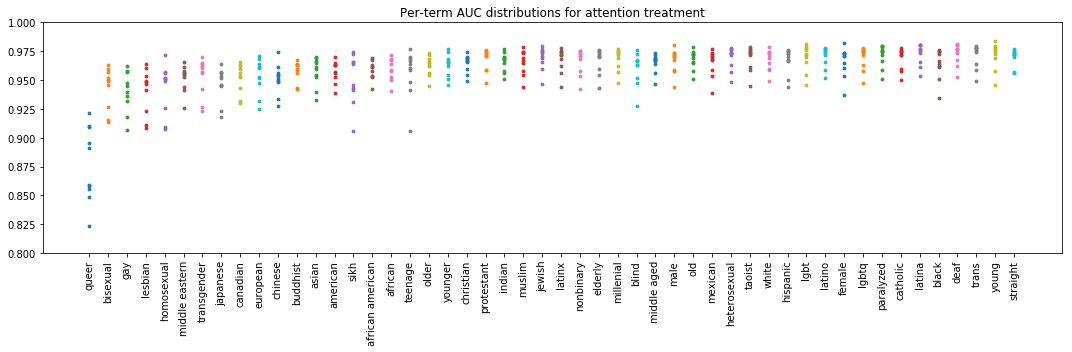

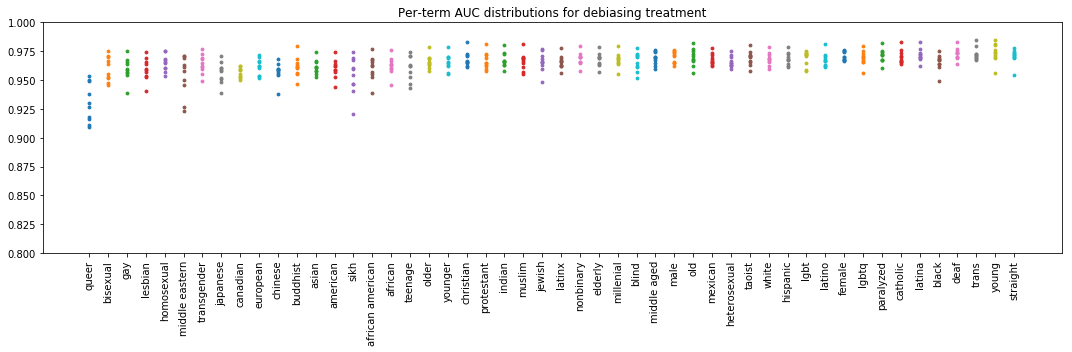

In [105]:
for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                   ('attention treatment', 'attention_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_madlibs_aucs, 'subgroup', auc_collection_col, title='Per-term AUC distributions for ' + title,
        file_name='madlibs')

### Per-term  AUCs on the wikipedia dataset

In [106]:
model_bias_analysis.add_subgroup_columns_from_text(wiki_test, 'text', madlibs_terms)

In [107]:
%%time
_raw_term_wiki_aucs = model_bias_analysis.per_subgroup_aucs(wiki_test, madlibs_terms, all_model_families_names, 'label')

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.12 s


In [108]:
_term_wiki_aucs = _raw_term_wiki_aucs.rename(columns=column_renamer).sort_values('orig_mean')

We don't see a strong effect in per-term pinned AUCs on the wikipedia test set. This isn't surprising, as the dataset bias affects the test set too: there are few non-toxic examples using the bias terms, and so the AUC of the original models does not suffer.

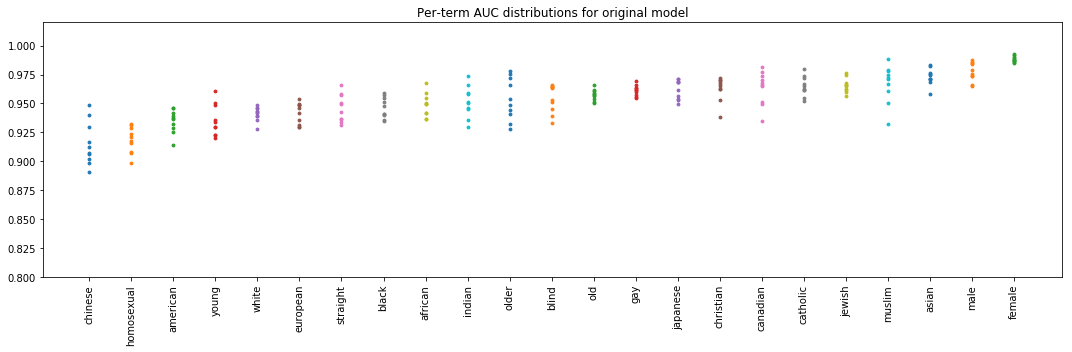

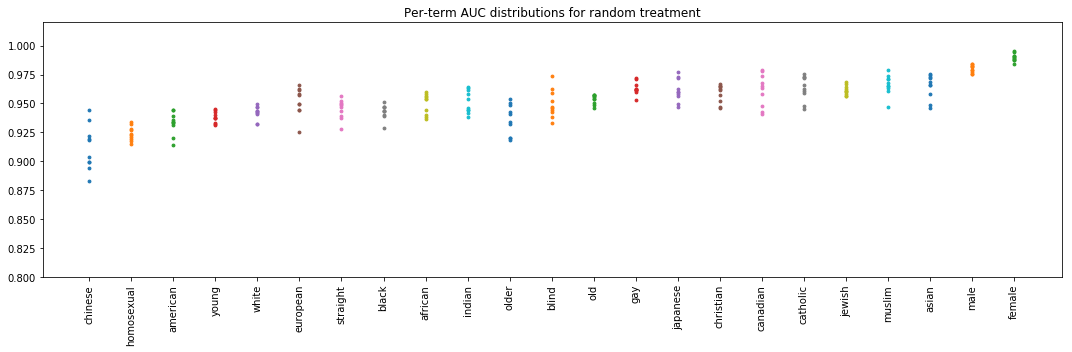

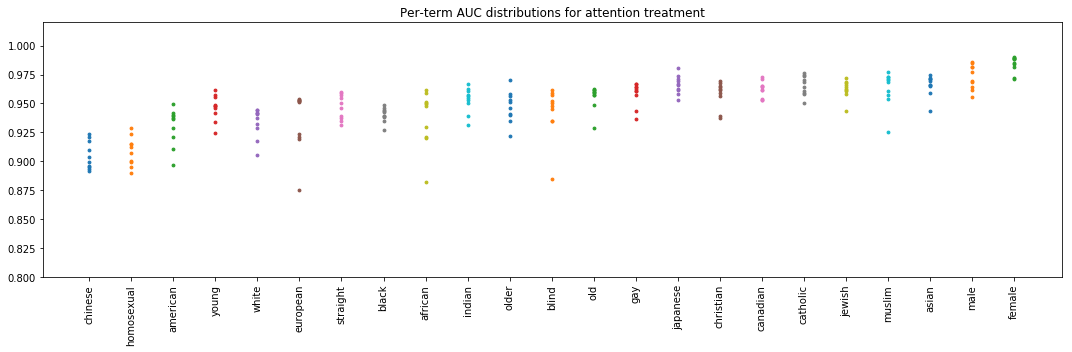

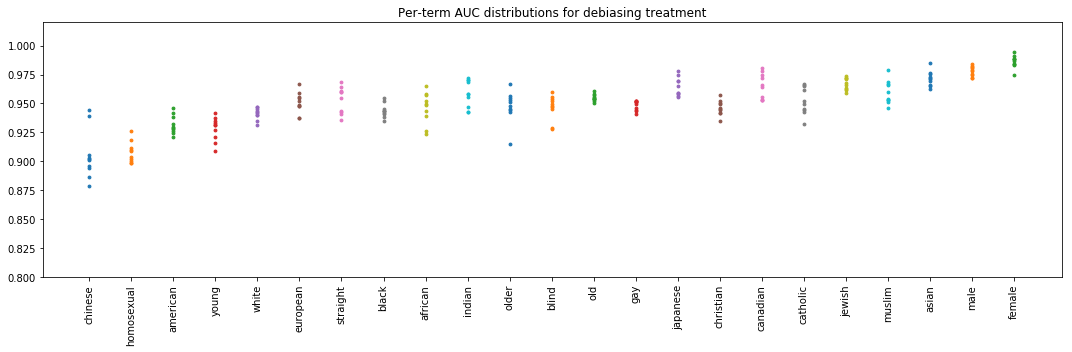

In [110]:
# AUC on tiny datasets is very noisy.
_term_wiki_aucs_nottiny = _term_wiki_aucs[_term_wiki_aucs['subset_size'] > 50]

for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                    ('attention treatment', 'attention_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_subgroup_scatterplots(_term_wiki_aucs_nottiny, 'subgroup', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title, y_lim=(0.8, 1.02),
                                              file_name='wiki')

## Qualitative look

In [111]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))
    plt.hist([x['median'] for x in median_scores])
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 10])

0.019  (std: 0.0257)  i am a music person
0.024  (std: 0.0413)  i am a box person
0.057  (std: 0.0457)  i am a teacher person
0.088  (std: 0.0709)  i am a christian person
0.104  (std: 0.1219)  i am a wikipedia person
0.120  (std: 0.0999)  i am a straight person
0.142  (std: 0.0663)  i am a heterosexual person
0.166  (std: 0.1482)  i am a muslim person
0.172  (std: 0.0706)  i am a white person
0.186  (std: 0.1781)  i am a jewish person
0.197  (std: 0.0945)  i am a tall person
0.200  (std: 0.1756)  i am a feminist person
0.384  (std: 0.1356)  i am a black person
0.703  (std: 0.1992)  i am a transgender person
0.747  (std: 0.1936)  i am a lesbian person
0.757  (std: 0.1478)  i am a gay person
0.762  (std: 0.1951)  i am a homosexual person
0.815  (std: 0.1985)  i am a bisexual person
0.860  (std: 0.0677)  i am a jew person
0.884  (std: 0.0822)  i am a queer person


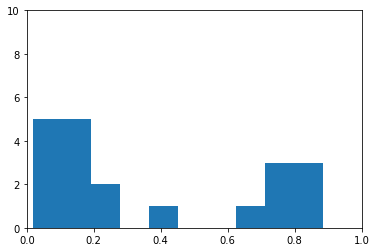

In [112]:
_print_template_scores(wiki_models)

0.021  (std: 0.0086)  i am a music person
0.027  (std: 0.0327)  i am a box person
0.057  (std: 0.0461)  i am a teacher person
0.077  (std: 0.0794)  i am a wikipedia person
0.084  (std: 0.0777)  i am a heterosexual person
0.107  (std: 0.0840)  i am a straight person
0.119  (std: 0.0556)  i am a white person
0.121  (std: 0.1027)  i am a christian person
0.160  (std: 0.1158)  i am a muslim person
0.167  (std: 0.1335)  i am a tall person
0.195  (std: 0.1459)  i am a jewish person
0.223  (std: 0.0709)  i am a feminist person
0.311  (std: 0.0950)  i am a black person
0.594  (std: 0.1650)  i am a lesbian person
0.601  (std: 0.2042)  i am a homosexual person
0.629  (std: 0.1819)  i am a transgender person
0.665  (std: 0.1689)  i am a gay person
0.710  (std: 0.1671)  i am a bisexual person
0.827  (std: 0.1014)  i am a jew person
0.851  (std: 0.0584)  i am a queer person


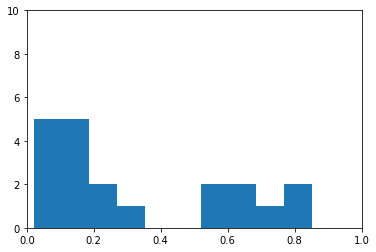

In [113]:
_print_template_scores(random_models)

0.019  (std: 0.0195)  i am a music person
0.035  (std: 0.0185)  i am a box person
0.056  (std: 0.0266)  i am a teacher person
0.077  (std: 0.0681)  i am a straight person
0.088  (std: 0.0670)  i am a christian person
0.094  (std: 0.1014)  i am a feminist person
0.100  (std: 0.0972)  i am a wikipedia person
0.118  (std: 0.0754)  i am a white person
0.119  (std: 0.0712)  i am a heterosexual person
0.160  (std: 0.0787)  i am a tall person
0.189  (std: 0.1284)  i am a transgender person
0.196  (std: 0.1101)  i am a muslim person
0.218  (std: 0.0569)  i am a jewish person
0.241  (std: 0.1042)  i am a gay person
0.244  (std: 0.0976)  i am a lesbian person
0.318  (std: 0.1511)  i am a black person
0.342  (std: 0.1126)  i am a bisexual person
0.364  (std: 0.1351)  i am a homosexual person
0.696  (std: 0.1353)  i am a queer person
0.805  (std: 0.0989)  i am a jew person


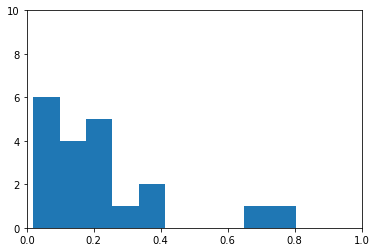

In [114]:
_print_template_scores(debias_models)

0.024  (std: 0.0159)  i am a music person
0.047  (std: 0.0385)  i am a box person
0.080  (std: 0.1138)  i am a christian person
0.082  (std: 0.0465)  i am a teacher person
0.102  (std: 0.0575)  i am a heterosexual person
0.104  (std: 0.0650)  i am a straight person
0.110  (std: 0.1082)  i am a wikipedia person
0.131  (std: 0.0681)  i am a white person
0.170  (std: 0.1058)  i am a muslim person
0.179  (std: 0.0887)  i am a tall person
0.197  (std: 0.1077)  i am a jewish person
0.230  (std: 0.0956)  i am a feminist person
0.371  (std: 0.1054)  i am a black person
0.481  (std: 0.1277)  i am a transgender person
0.490  (std: 0.1260)  i am a lesbian person
0.494  (std: 0.1496)  i am a gay person
0.508  (std: 0.1355)  i am a bisexual person
0.510  (std: 0.1345)  i am a homosexual person
0.750  (std: 0.1385)  i am a queer person
0.769  (std: 0.1107)  i am a jew person


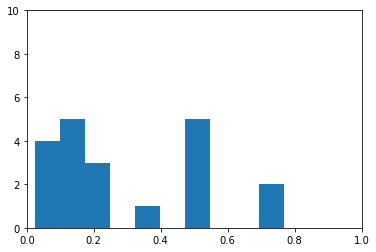

In [115]:
_print_template_scores(atn_models)

### Equality of Opportunity

To evaluate equality of opportunity, we compare false negative rates on a per-term basis.

In [148]:
def neg_table_means(term_neg_rates):
    """Helper to display just the mean values of the negative rates."""
    return (term_neg_rates
            [['subgroup',
              'orig_fnr_mean',
              'attention_fnr_mean',
              'attention_tnr_mean',
              'random_fnr_mean',
              'debias_fnr_mean',
              'orig_tnr_mean',
              'random_tnr_mean',
              'debias_tnr_mean',
            ]]
            .sort_values('orig_fnr_mean')
           )

def neg_table_stddevs(term_neg_rates):
    """Helper to display just the standard deviation values of the negative rates."""
    return (term_neg_rates
            [['subgroup',
              'orig_tnr_std',
              'attention_tnr_std',
              'attention_fnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_fnr_mean',  # just for sorting
            ]]
            .sort_values('orig_fnr_mean')
            .drop('orig_fnr_mean', axis=1)
           )

### Threshold 0.5

In [149]:
%%time

# threshold = .50 

_raw_term_neg_rates_50 = model_bias_analysis.per_subgroup_negative_rates(madlibs, madlibs_terms, all_model_families_names, 0.5, 'label')

CPU times: user 6.62 s, sys: 7.72 ms, total: 6.63 s
Wall time: 6.62 s


In [150]:
_term_neg_rates_50 = _raw_term_neg_rates_50.rename(columns=column_renamer)

In [151]:
neg_table_means(_term_neg_rates_50)

,subgroup,orig_fnr_mean,attention_fnr_mean,attention_tnr_mean,random_fnr_mean,debias_fnr_mean,orig_tnr_mean,random_tnr_mean,debias_tnr_mean
5,queer,0.000000,0.000132,0.035931,0.000000,0.000661,0.042008,0.029326,0.143989
1,gay,0.000661,0.003831,0.335139,0.001321,0.018098,0.160766,0.243593,0.543065
8,homosexual,0.000925,0.002642,0.314267,0.000925,0.009511,0.234082,0.276618,0.499472
2,bisexual,0.001057,0.002906,0.293527,0.000793,0.013606,0.187054,0.204624,0.456803
0,lesbian,0.001717,0.003170,0.299207,0.001321,0.030251,0.198283,0.293395,0.575561
3,transgender,0.001849,0.005020,0.431704,0.002378,0.021797,0.246367,0.333421,0.536328
37,sikh,0.005680,0.011096,0.419815,0.008190,0.012285,0.364069,0.433950,0.365522
43,teenage,0.006605,0.006869,0.591413,0.010172,0.013606,0.448481,0.521136,0.479524
47,blind,0.008587,0.005945,0.575561,0.011625,0.006737,0.566843,0.654557,0.517041
6,lgbt,0.012021,0.041480,0.837120,0.015059,0.071202,0.611493,0.666711,0.885469


In [152]:
neg_table_stddevs(_term_neg_rates_50)

,subgroup,orig_tnr_std,attention_tnr_std,attention_fnr_std,random_tnr_std,debias_tnr_std,orig_tnr_std,random_tnr_std,debias_tnr_std
5,queer,0.051779,0.046445,0.000396,0.038171,0.095616,0.051779,0.038171,0.095616
1,gay,0.101918,0.154008,0.004555,0.176520,0.221290,0.101918,0.176520,0.221290
8,homosexual,0.174337,0.123958,0.003070,0.212668,0.147287,0.174337,0.212668,0.147287
2,bisexual,0.128894,0.112055,0.004333,0.156875,0.204409,0.128894,0.156875,0.204409
0,lesbian,0.130267,0.092433,0.003505,0.177127,0.235893,0.130267,0.177127,0.235893
3,transgender,0.159502,0.097039,0.005902,0.189124,0.217595,0.159502,0.189124,0.217595
37,sikh,0.152978,0.162225,0.018316,0.204376,0.269680,0.152978,0.204376,0.269680
43,teenage,0.193909,0.144443,0.004530,0.209671,0.210735,0.193909,0.209671,0.210735
47,blind,0.139847,0.091341,0.005091,0.162415,0.151262,0.139847,0.162415,0.151262
6,lgbt,0.174900,0.120585,0.034005,0.172262,0.116187,0.174900,0.172262,0.116187


### Threshold using per-model equal error rate on overall madlibs dataset

In [129]:
%%time

# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# Flattened list of all models.
_all_model_names = []
for model_family_names in all_model_families_names:
    _all_model_names.extend(model_family_names)
_model_eers_madlibs = model_bias_analysis.per_model_eer(madlibs, 'label', _all_model_names)

CPU times: user 40.3 s, sys: 2.21 ms, total: 40.3 s
Wall time: 40.2 s


In [130]:
%%time
_raw_term_neg_rates_madlibs_eer = model_bias_analysis.per_subgroup_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, 'label')

CPU times: user 6.57 s, sys: 0 ns, total: 6.57 s
Wall time: 6.57 s


In [131]:
_term_neg_rates_madlibs_eer = _raw_term_neg_rates_madlibs_eer.rename(columns=column_renamer)

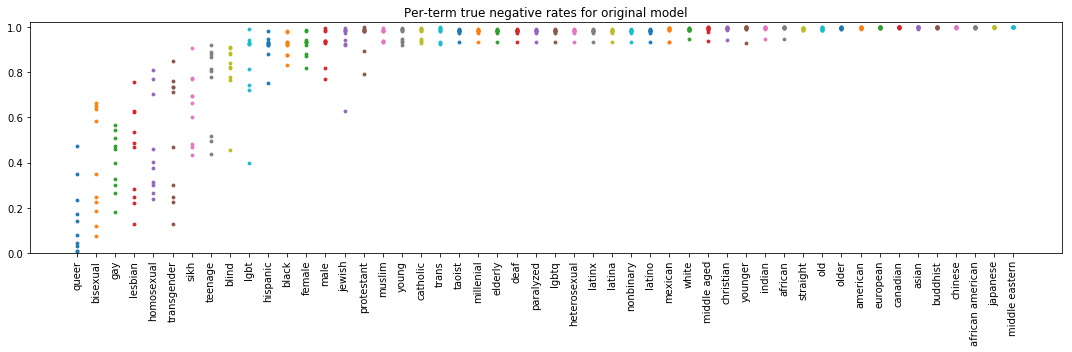

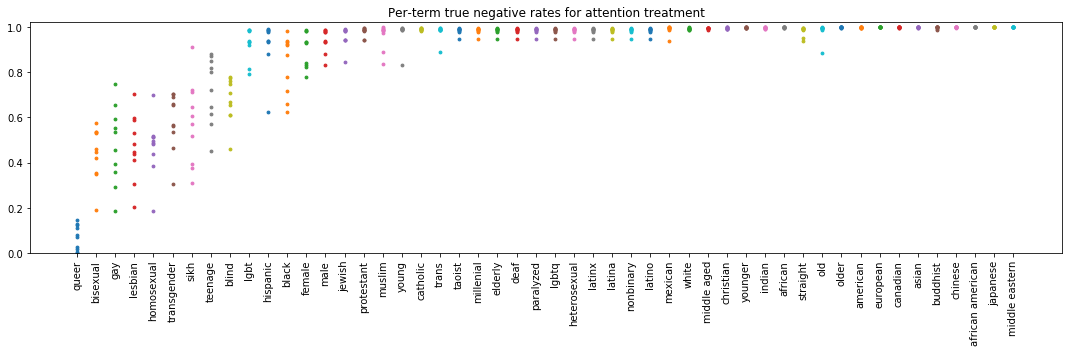

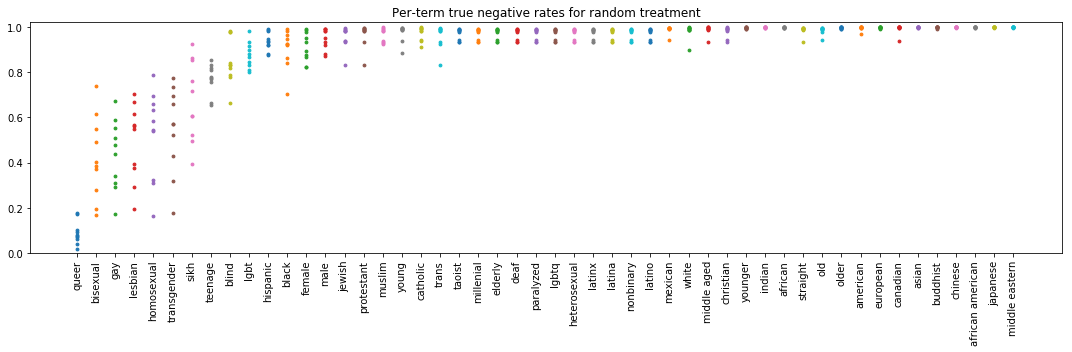

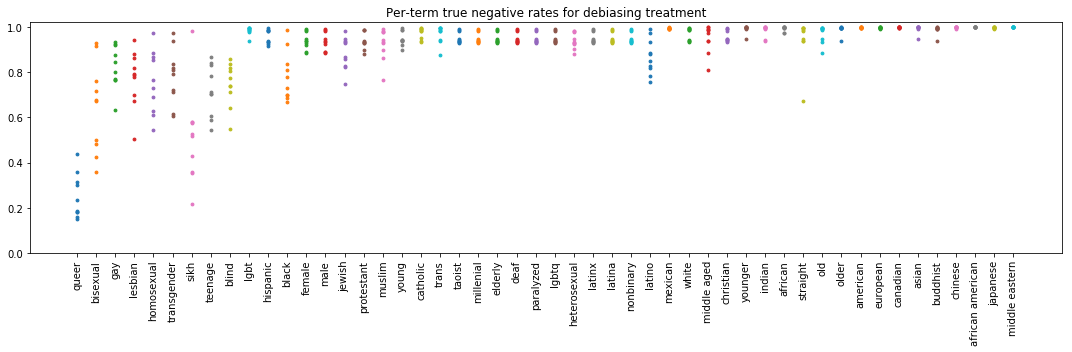

In [132]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                            ('attention treatment', 'attention_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_madlibs_eer_tnr_sorted, 'subgroup', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title, file_name='madlibs')

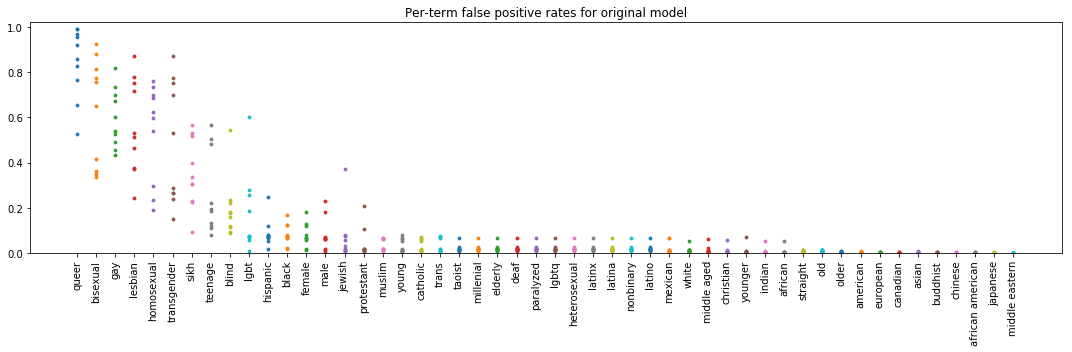

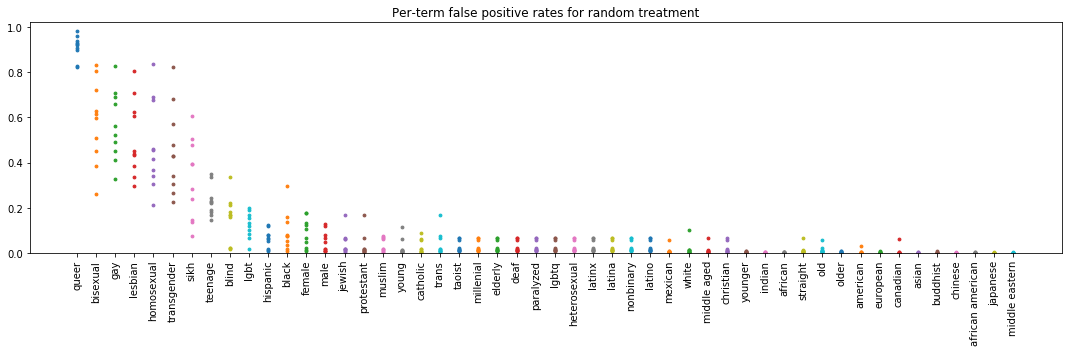

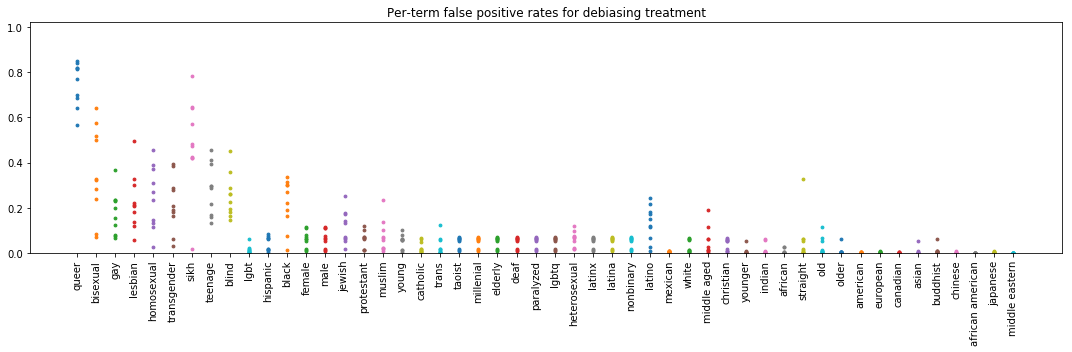

In [133]:
# False positive rates: 1 - TNR. This is just the above graphs except flipped to show false positives instead of true negatives.

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                                ('attention treatment', 'attention_tnr_values'),

                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    term_fpr_values = []
    for _i, row in _term_neg_rates_madlibs_eer_tnr_sorted.iterrows():
        tnr_values = row[tnr_values_col]
        fpr_values = [1 - tnr for tnr in tnr_values]
        term_fpr_values.append({'subgroup': row['subgroup'], 'fpr_values': fpr_values})
    fpr_df = pd.DataFrame(term_fpr_values)
    model_bias_analysis.per_subgroup_scatterplots(
        fpr_df, 'subgroup', 'fpr_values', y_lim=(0, 1.02),
        title='Per-term false positive rates for ' + title,
        file_name='madlibs_' + tnr_values_col)

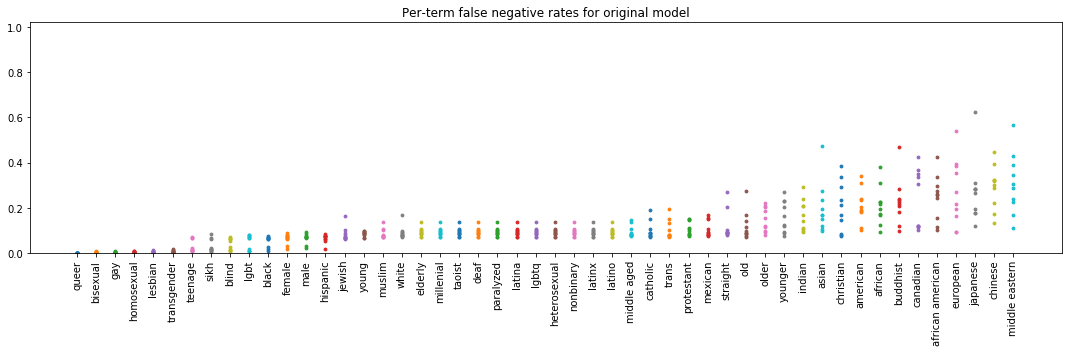

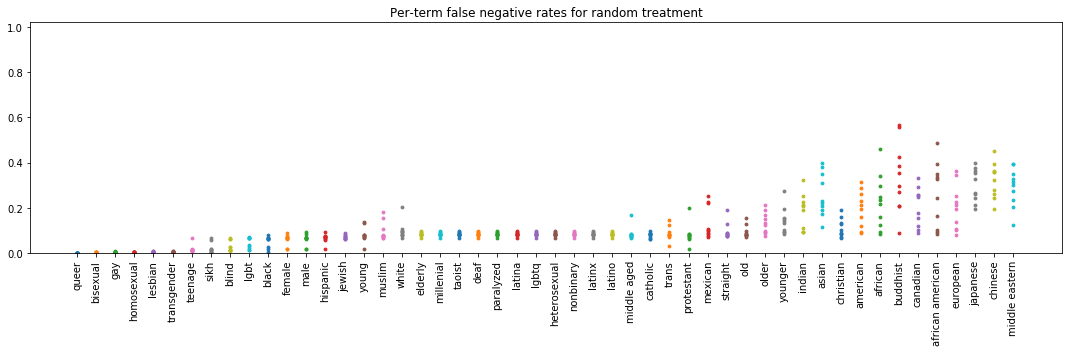

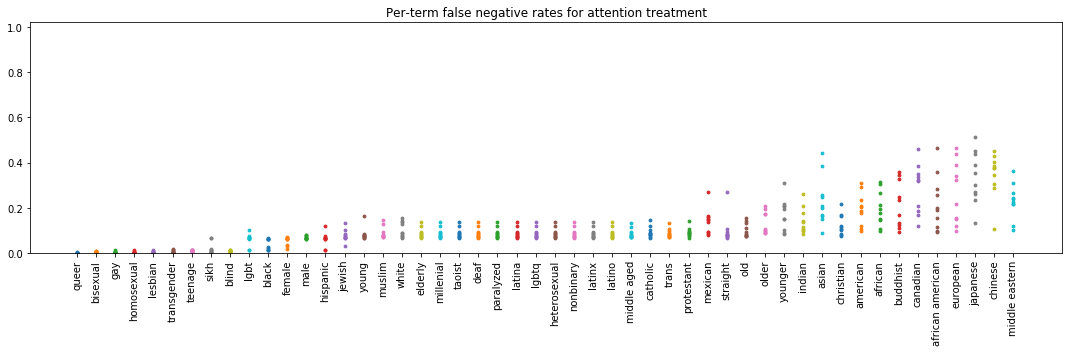

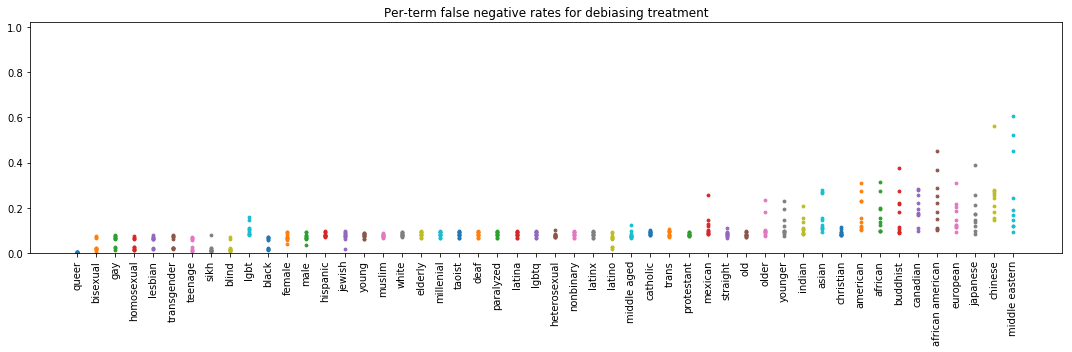

In [141]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_madlibs_eer_fnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                            ('attention treatment', 'attention_fnr_values'),

                              ('debiasing treatment', 'debias_fnr_values')]:
    #_term_neg_rates_madlibs_eer_fnr_sorted
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_madlibs_eer_fnr_sorted, 'subgroup', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title,
        file_name='madlibs')

### Threshold using per-model equal error rate on Wikipedia test set

The EERs computed on the wikipedia test set are similar, and so we don't see much difference in the per-term negative rates plots.

In [142]:
%%time

# Compute the equal error rate for all models on the wikipedia dataset.

_model_eers_wiki = model_bias_analysis.per_model_eer(wiki_test, 'label', _all_model_names)

CPU times: user 12.7 s, sys: 3.44 ms, total: 12.7 s
Wall time: 12.7 s


In [143]:
%%time
_raw_term_neg_rates_wiki_eer = model_bias_analysis.per_subgroup_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_wiki, 'label')
_term_neg_rates_wiki_eer = _raw_term_neg_rates_wiki_eer.rename(columns=column_renamer)

CPU times: user 6.59 s, sys: 3.73 ms, total: 6.6 s
Wall time: 6.59 s


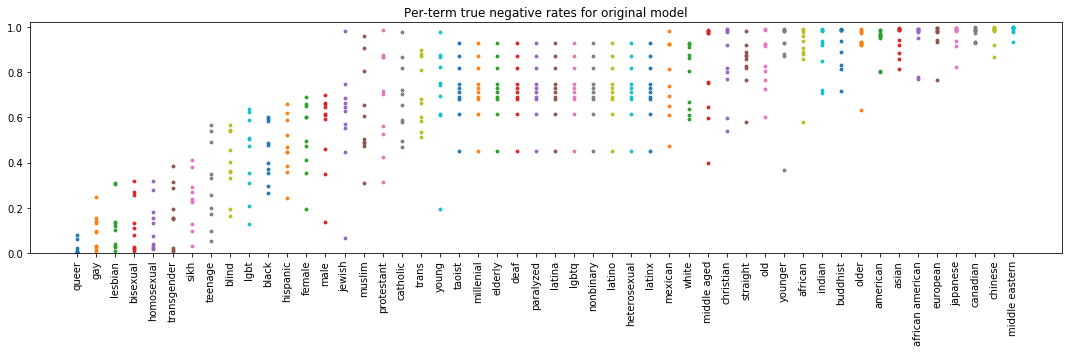

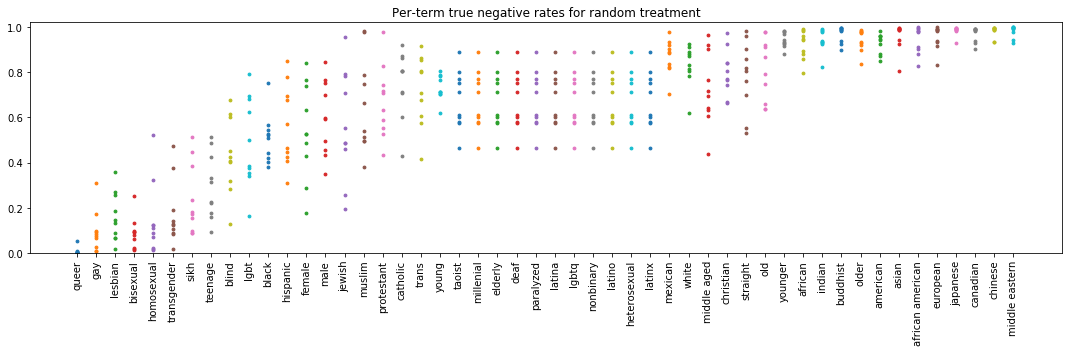

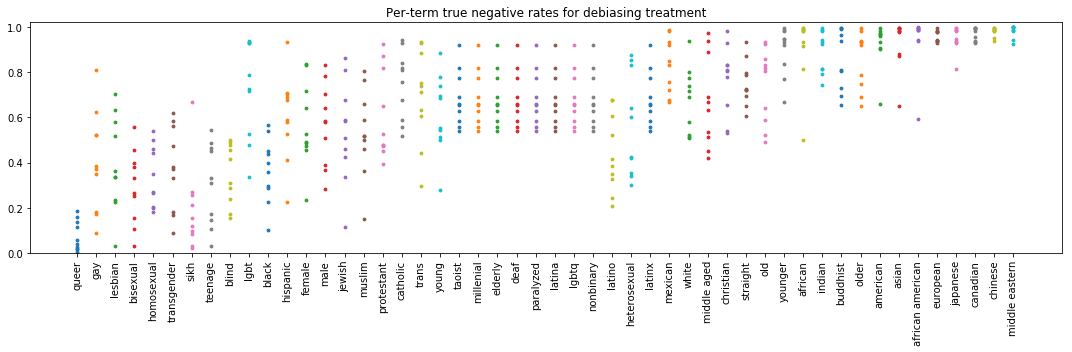

In [137]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_wiki_eer_tnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                                ('attention treatment', 'attention_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_wiki_eer_tnr_sorted, 'subgroup', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title, file_name='wiki')

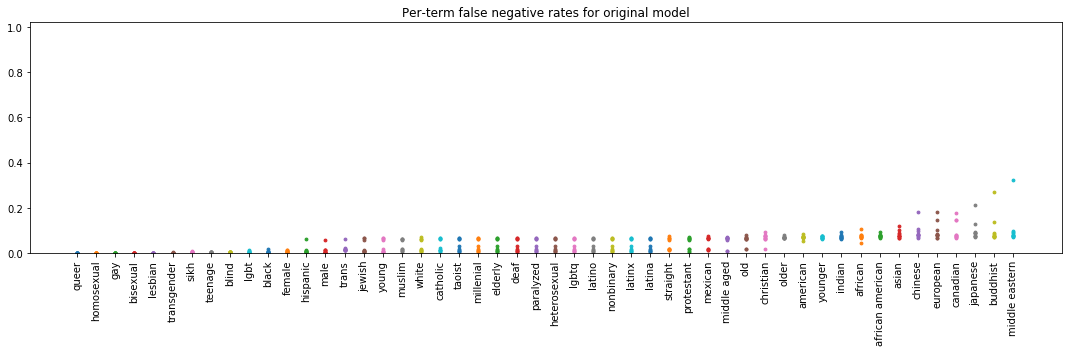

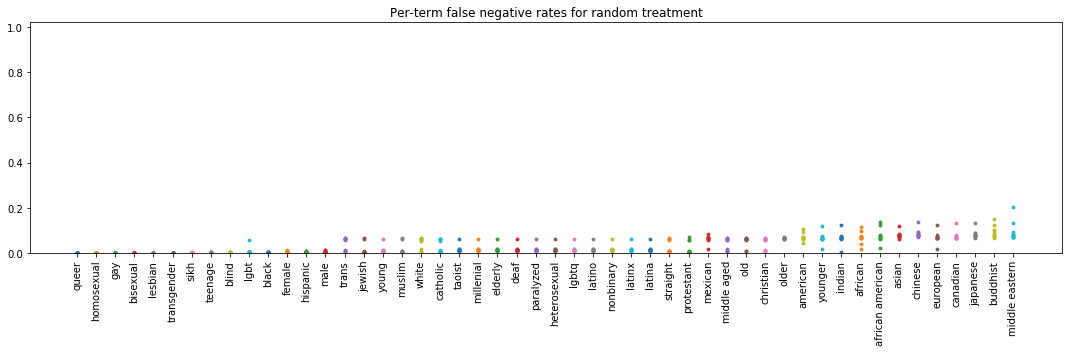

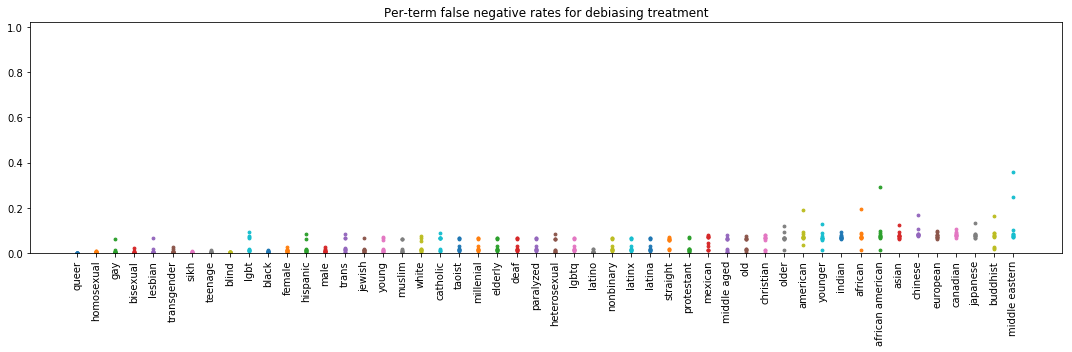

In [138]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_wiki_eer_fnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                                ('attention treatment', 'attention_tnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_wiki_eer_fnr_sorted, 'subgroup', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title, file_name='wiki')

In [ ]:
model_bias_analysis.per_subgroup_fnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, False)

In [ ]:
model_bias_analysis.per_subgroup_tnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, False)

In [ ]:
model_bias_analysis.per_subgroup_auc_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, False)